<a href="https://colab.research.google.com/github/Derrick-Majani/Job_Search/blob/main/Jobs_Over_UnderSampling3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Businees Context

The Ed Tech companies working on data science usually receive many
registrations for the training programs of the companies before officially
giving them a permanent role. Among those trainees, the companies want
to know which candidates are really want to work for them or will look
for a new employment after training time. This will help to reduce the
training cost, and bring higher levels of satisfaction and retention. This
work is performed to interpret the main factors impacting to candidate
decision and then build a prediction model to predict the probability of a
candidate will look for a new job or will work for the company using the
current credentials, demographics, experience data, etc.

### Objective
Ed Tech company wants to predict the likelihood of the candidates with
the intention to leave or do not leave the company after training periods. As data scientist at this Ed Tech company,you need to work on these and interpret the main factors impacting to candidate decision
and then build a prediction model to predict the probability of a candidate will
look for a new job or will work for the company using the current credentials,
demographics, experience data, etc.


### Data Description

* enrollee_id: Unique ID for the candidate

* city: City code

* city_ development _index: Development index of the city (scaled)

* gender: Gender of the candidate

* relevent_experience: Relevant experience of the candidate

* enrolled_university: Type of University course enrolled if any

* education_level: Education level of candidate

* major_discipline: Education major discipline of the candidate

* experience: Candidate total experience in years

* company_size: No of employees in current employer's company

* company_type: Type of current employer

* lastnewjob: Difference in years between previous job and current job

* training_hours: training hours completed

* target: 0 – Not looking for a job change, 1 – Looking for a job change


### Import Data

In [204]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import io
import os
import sys

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores and split data
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To impute missing values
from sklearn.impute import KNNImputer

# To build a logistic regression model
from sklearn.linear_model import LogisticRegression

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To suppress the warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

In [2]:
# Use Local drives to upload the csv on google colab
from google.colab import files
uploaded = files.upload()

Saving jobs_data.csv to jobs_data.csv


In [273]:
df = pd.read_csv("jobs_data.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [274]:
df.shape

(19158, 14)

In [275]:
df.duplicated().sum()

0

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

## Statistical Analysis

In [277]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
city_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


In [278]:
# Print categorical summary
print('Categorical Summary:')
df.describe(include=['object']).T

Categorical Summary:


,count,unique,top,freq
city,19158,123,city_103,4355
gender,14650,3,Male,13221
relevent_experience,19158,2,Has relevent experience,13792
enrolled_university,18772,3,no_enrollment,13817
education_level,18698,5,Graduate,11598
major_discipline,16345,6,STEM,14492
experience,19093,22,>20,3286
company_size,13220,8,50-99,3083
company_type,13018,6,Pvt Ltd,9817
last_new_job,18735,6,1,8040


## Univariate Analysis

In [279]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df, x=feature, ax=ax_box2, showmeans=True, color="white"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

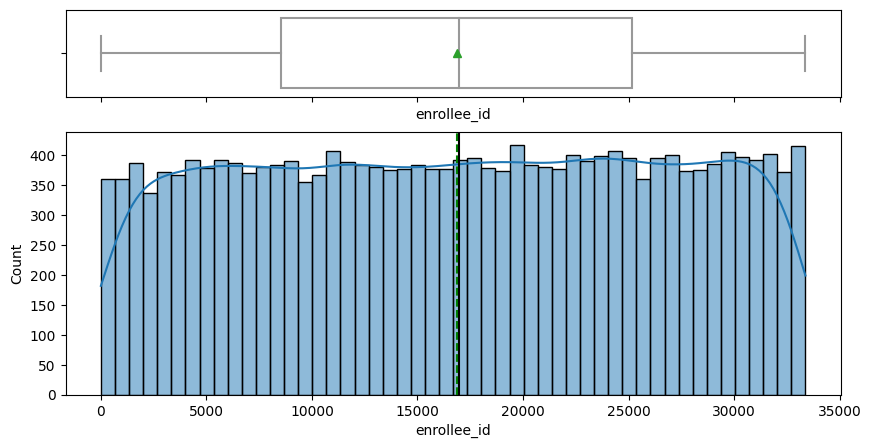

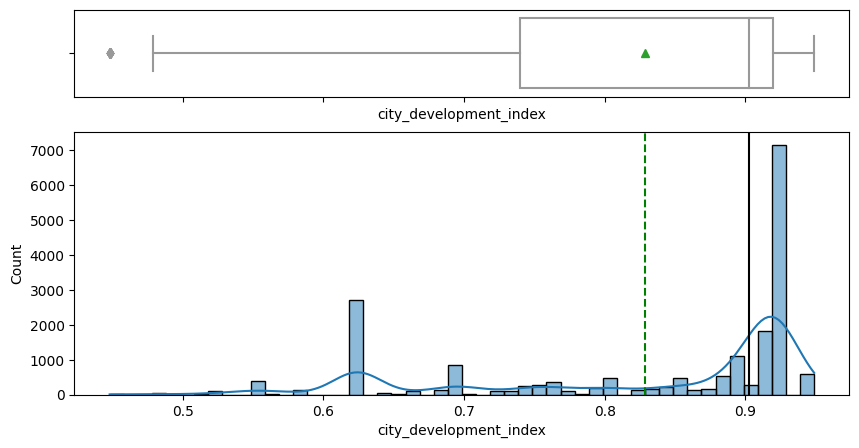

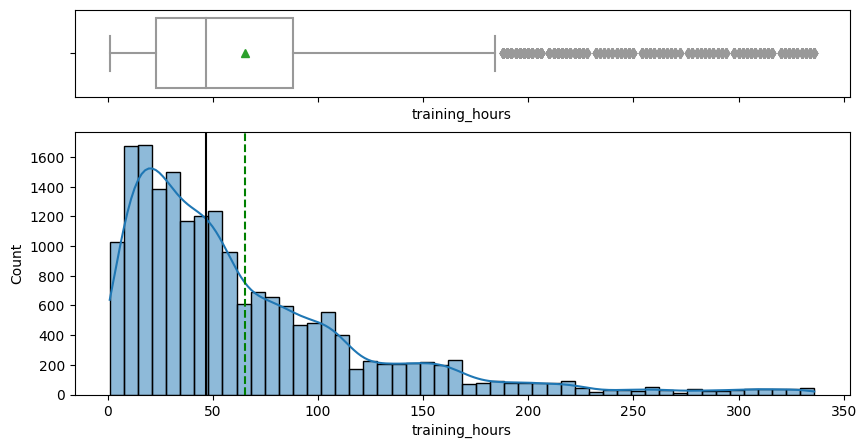

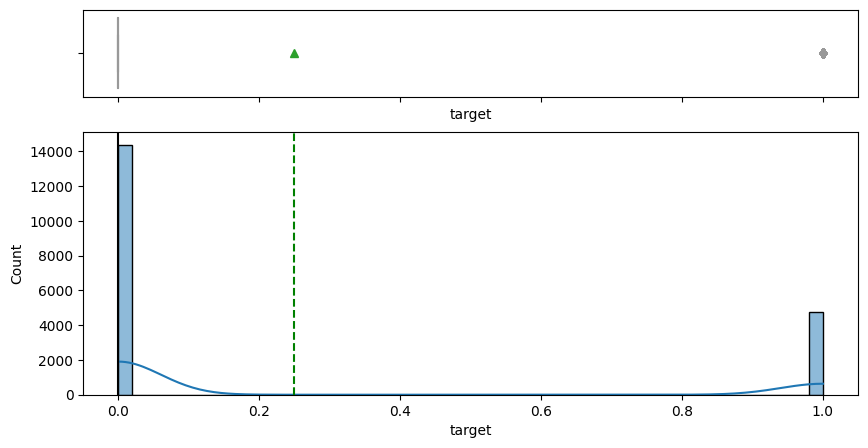

In [280]:
# selecting numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

for item in num_cols:
    histogram_boxplot(df, item, bins=50, kde=True, figsize=(10, 5))

## Missing Values

In [281]:
def missing_check(df):
    total = df.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data # return the dataframe
missing_check(df)

,Total,Percent
company_type,6140,0.320493
company_size,5938,0.309949
gender,4508,0.235306
major_discipline,2813,0.146832
education_level,460,0.024011
last_new_job,423,0.022080
enrolled_university,386,0.020148
experience,65,0.003393
enrollee_id,0,0.000000
city,0,0.000000


In [282]:
df.loc[(df['company_type'].isnull()) |
        (df['company_size'].isnull()) |
        (df['gender'].isnull()) |
        (df['major_discipline'].isnull()) |
        (df['education_level'].isnull()) |
        (df['last_new_job'].isnull()) |
        (df['enrolled_university'].isnull())]


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19151,11385,city_149,0.689,Male,No relevent experience,Full time course,Graduate,NaN,2,NaN,NaN,1,60,0.0
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


### Handling Missing Values for Categorigal Values

<Axes: >

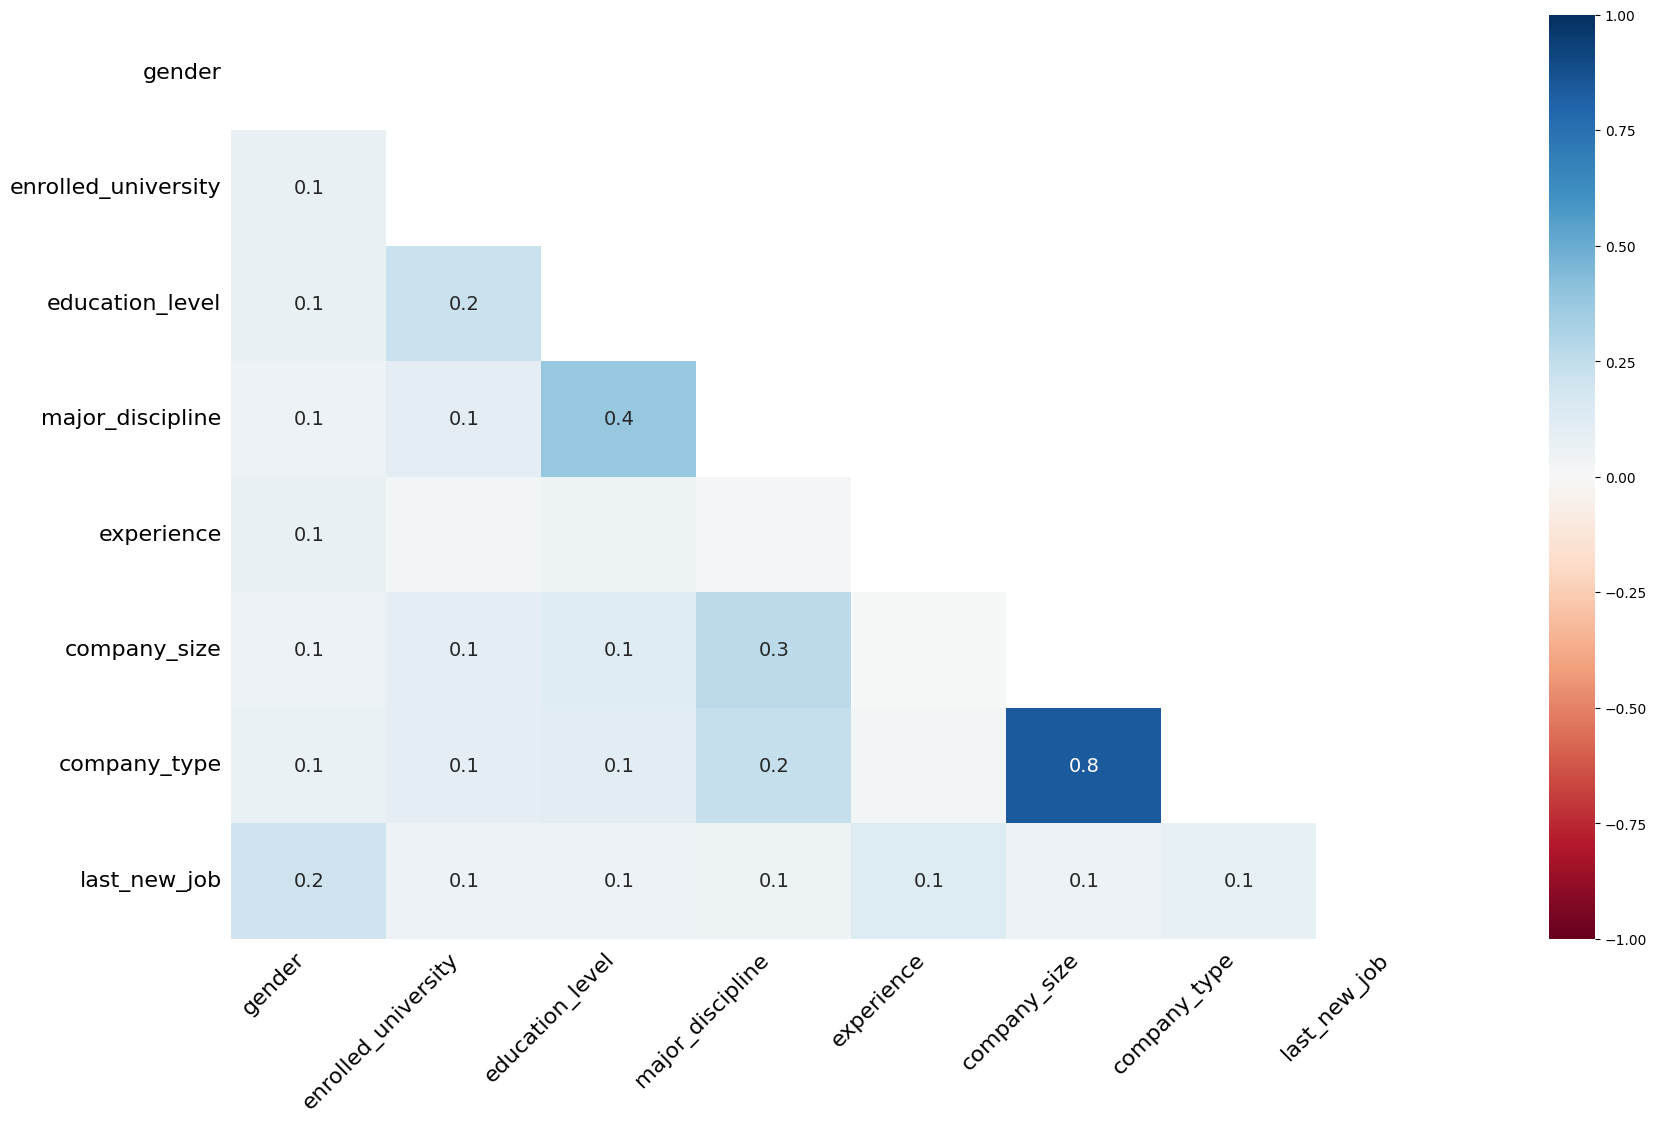

In [283]:
# Program to visualize missing values in dataset

# Importing the libraries
import pandas as pd
import missingno as msno

# Visualize the correlation between the number of
# missing values in different columns as a heatmap
msno.heatmap(df)


In [284]:
from scipy.stats import chi2_contingency
# Select the categorical columns to test
cat_cols = ['company_type', 'company_size', 'gender', 'major_discipline','education_level','last_new_job','enrolled_university','experience','city']

# Create an empty dataframe for results
results_df = pd.DataFrame(columns=['Column 1', 'Column 2', 'Chi-Square', 'P-Value'])

# Loop through each column pair and perform chi-square test
for i, col1 in enumerate(cat_cols):
    for j, col2 in enumerate(cat_cols[i+1:]):
        contingency_table = pd.crosstab(df[col1], df[col2])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        results_df = results_df.append({'Column 1': col1, 'Column 2': col2, 'Chi-Square': chi2, 'P-Value': p}, ignore_index=True)

# Print the results
results_df

,Column 1,Column 2,Chi-Square,P-Value
0,company_type,company_size,2311.620776,0.000000e+00
1,company_type,gender,55.927171,2.118409e-08
2,company_type,major_discipline,87.369918,7.650566e-09
3,company_type,education_level,337.658690,1.546165e-59
4,company_type,last_new_job,404.534476,3.661514e-70
5,company_type,enrolled_university,258.855216,7.442616e-50
6,company_type,experience,276.274026,2.431991e-17
7,company_type,city,1172.690938,2.142081e-39
8,company_size,gender,15.109826,3.706885e-01
9,company_size,major_discipline,63.050823,2.516179e-03


In [285]:
# enrollee_id is unique for each candidate and might not add value to modeling
df.drop(["enrollee_id"], axis=1, inplace=True)

In [286]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))


col_0,% observations
city,
city_1,0.001357
city_10,0.004489
city_100,0.014354
city_101,0.003915
city_102,0.015868
...,...
city_93,0.001357
city_94,0.001357
city_97,0.005429


col_0,% observations
gender,
Female,0.084505
Male,0.902457
Other,0.013038


col_0,% observations
relevent_experience,
Has relevent experience,0.719908
No relevent experience,0.280092


col_0,% observations
enrolled_university,
Full time course,0.200139
Part time course,0.063818
no_enrollment,0.736043


col_0,% observations
education_level,
Graduate,0.620280
High School,0.107872
Masters,0.233234
Phd,0.022141
Primary School,0.016472


col_0,% observations
major_discipline,
Arts,0.015479
Business Degree,0.020006
Humanities,0.040930
No Major,0.013643
Other,0.023310
STEM,0.886632


col_0,% observations
experience,
1,0.028754
10,0.051590
11,0.034777
12,0.025873
13,0.020898
14,0.030692
15,0.035929
16,0.026607
17,0.017912


col_0,% observations
company_size,
10/49,0.111271
100-500,0.194478
1000-4999,0.100454
10000+,0.152723
50-99,0.233207
500-999,0.066339
5000-9999,0.042587
<10,0.098941


col_0,% observations
company_type,
Early Stage Startup,0.046320
Funded Startup,0.076894
NGO,0.040022
Other,0.009295
Public Sector,0.073360
Pvt Ltd,0.754110


col_0,% observations
last_new_job,
1,0.429143
2,0.154790
3,0.054657
4,0.054924
>4,0.175607
never,0.130878


In [287]:
df['gender'] = df['gender'].fillna('Unknown')


In [288]:
df['gender'].value_counts()

Male       13221
Unknown     4508
Female      1238
Other        191
Name: gender, dtype: int64

#### Handling of ANova

In [289]:
import pandas as pd
from scipy import stats

# Create a DataFrame with the categorical and numerical variables
data = df[['city','city_development_index']]

# Perform the ANOVA test
result = stats.f_oneway(*[group['city_development_index'] for name, group in data.groupby('city')])

# Print the p-value from the test
print("p-value:", result.pvalue)


p-value: 0.0


- The p-value indicates the significance of the relationship. If the p-value is below a chosen significance level (e.g., 0.05), it suggests that there is a significant relationship between the categorical variable (city) and the numerical variable (city_development_index

In [290]:
# Define the quartile ranges
quartiles = pd.qcut(data['city_development_index'], q=[0, 0.25, 0.50, 1], labels=['Under_developed', 'Developing', 'Developed'])

# Add the quartile ranges as a new column in the DataFrame
df['city'] = quartiles

# Print the updated DataFrame
df

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,Developed,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,Developing,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,Under_developed,0.624,Unknown,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,Developing,0.789,Unknown,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,Developing,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,Developing,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,Developed,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,Developed,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,Developing,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [291]:
df['city'].value_counts()

Developed          9561
Under_developed    4838
Developing         4759
Name: city, dtype: int64

In [292]:
# This loop prints the names of the columns where there is
# at least one entry containing the character '<' or '>'
money_cols = []
for colname in df.columns[df.dtypes == 'object']:  # Only need to consider string columns
    if df[colname].str.contains('<|>').any():  # Using `.str.contains` to check for '<' or '>'
        money_cols.append(colname)
print(money_cols)


['experience', 'company_size', 'last_new_job']


In [293]:
# Display the samples from the money_cols columns
for colname in money_cols:
    print(df[colname])


0        >20
1         15
2          5
3         <1
4        >20
        ... 
19153     14
19154     14
19155    >20
19156     <1
19157      2
Name: experience, Length: 19158, dtype: object
0            NaN
1          50-99
2            NaN
3            NaN
4          50-99
          ...   
19153        NaN
19154        NaN
19155      50-99
19156    500-999
19157        NaN
Name: company_size, Length: 19158, dtype: object
0            1
1           >4
2        never
3        never
4            4
         ...  
19153        1
19154        4
19155        4
19156        2
19157        1
Name: last_new_job, Length: 19158, dtype: object


In [294]:
# Display the value counts of items in the respective columns
for colname in money_cols:
    print(df[colname].value_counts())


>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64
1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: last_new_job, dtype: int64


In [295]:
# This loop prints the names of the columns where there is
# at least one entry containing the character '<' or '>'
money_cols = []
colname = 'experience'
if df[colname].str.contains('<|>').any():  # Using `.str.contains` to check for '<' or '>'
    money_cols.append(colname)
print(money_cols)


['experience']


In [296]:
# Display the value counts of items in the respective columns
for colname in money_cols:
    print(df[colname].value_counts())


>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64


In [297]:
data = df.copy()

In [298]:
# Map Gender column
gender_mapping = {"Male": 0, "Female": 1, "Other": 2}
data['gender'] = data['gender'].map(gender_mapping)

# Map enrolled_university column
enrollment_mapping = {"no_enrollment": 0, "Part time course": 1, "Full time course": 2}
data['enrolled_university'] = data['enrolled_university'].map(enrollment_mapping)

# Map education_level column
education_mapping = {"Primary School": 0, "High School": 1, "Graduate": 2, "Masters": 3, "Phd": 4}
data['education_level'] = data['education_level'].map(education_mapping)

# Map major_discipline column
major_mapping = {"STEM": 0, "Business Degree": 1, "Arts": 2, "Humanities": 3, "No Major": 4, "Other": 5}
data['major_discipline'] = data['major_discipline'].map(major_mapping)

# Map experience column
experience_mapping = {"<1": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7, "8": 8, "9": 9,
                     "10": 10, "11": 11, "12": 12, "13": 13, "14": 14, "15": 15, "16": 16, "17": 17,
                     "18": 18, "19": 19, "20": 20, ">20": 21}
data['experience'] = data['experience'].map(experience_mapping)

# Map company_type column
company_type_mapping = {"Pvt Ltd": 0, "Funded Startup": 1, "Early Stage Startup": 2, "Other": 3,
                        "Public Sector": 4, "NGO": 5}
data['company_type'] = data['company_type'].map(company_type_mapping)

# Map company_size column
company_size_mapping = {"<10": 0, "10/49": 1, "100-500": 2, "1000-4999": 3, "10000+": 4, "50-99": 5, 
                        "500-999": 6, "5000-9999": 7}
data['company_size'] = data['company_size'].map(company_size_mapping)

# Map last_new_job column
last_new_job_mapping = {"never": 0, "1": 1, "2": 2, "3": 3, "4": 4, ">4": 5}
data['last_new_job'] = data['last_new_job'].map(last_new_job_mapping)


In [299]:
data.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,Developed,0.920,0.0,Has relevent experience,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,Developing,0.776,0.0,No relevent experience,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,Under_developed,0.624,NaN,No relevent experience,2.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,Developing,0.789,NaN,No relevent experience,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,Developing,0.767,0.0,Has relevent experience,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0


In [300]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,Developed,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,Developing,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,Under_developed,0.624,Unknown,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,Developing,0.789,Unknown,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,Developing,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Data Preparation for Modeliing

In [301]:
# Separating features and the target column
X = data.drop("target", axis=1)  # Drop the specified column
y = data["target"]


In [302]:
data.shape

(19158, 13)

In [303]:
from sklearn.model_selection import train_test_split

# Split data into training and remaining data (validation + testing)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=42)

# Split remaining data into validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Print the sizes of each split
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 11494
Validation set size: 3832
Testing set size: 3832


## Missing Value Treatment

In [304]:
# defining a list with names of columns that will be used for imputation
reqd_col_for_impute = [
    "gender",
    "enrolled_university",
    "education_level",
    "major_discipline",
    "experience",
    "company_size",
    "company_type",
    "last_new_job",
]

In [305]:
# defining the KNN imputer
imputer = KNNImputer(n_neighbors=5)

In [306]:
# Fit and transform the train data
X_train[reqd_col_for_impute] = imputer.fit_transform(X_train[reqd_col_for_impute])

In [307]:

# Transform the val data
X_val[reqd_col_for_impute] = imputer.transform(X_val[reqd_col_for_impute])

In [308]:
# Transform the test data
X_test[reqd_col_for_impute] = imputer.transform(X_test[reqd_col_for_impute])

In [309]:
X_train.isnull().sum()

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [310]:
X_val.isnull().sum()

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [311]:
X_test.isnull().sum()

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [312]:
X_test.shape

(3832, 12)

## Feuture Engineering

### Inverse mapping of categorical variables

In [313]:
# Define the inverse mappings
inverse_gender_mapping = {0: "Male", 1: "Female", 2: "Other"}
inverse_enrollment_mapping = {0: "no_enrollment", 1: "Part time course", 2: "Full time course"}
inverse_education_mapping = {0: "Primary School", 1: "High School", 2: "Graduate", 3: "Masters", 4: "Phd"}
inverse_major_mapping = {0: "STEM", 1: "Business Degree", 2: "Arts", 3: "Humanities", 4: "No Major", 5: "Other"}
inverse_experience_mapping = {0: "<1", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
                              10: "10", 11: "11", 12: "12", 13: "13", 14: "14", 15: "15", 16: "16", 17: "17",
                              18: "18", 19: "19", 20: "20", 21: ">20"}
inverse_company_type_mapping = {0: "Pvt Ltd", 1: "Funded Startup", 2: "Early Stage Startup", 3: "Other",
                                4: "Public Sector", 5: "NGO"}
inverse_company_size_mapping = {0: "<10", 1: "10/49", 2: "100-500", 3: "1000-4999", 4: "10000+", 5: "50-99",
                                6: "500-999", 7: "5000-9999"}
inverse_last_new_job_mapping = {0: "never", 1: "1", 2: "2", 3: "3", 4: "4", 5: ">4"}

# Inverse map the columns in X_train
X_train['gender'] = X_train['gender'].map(inverse_gender_mapping)
X_train['enrolled_university'] = X_train['enrolled_university'].map(inverse_enrollment_mapping)
X_train['education_level'] = X_train['education_level'].map(inverse_education_mapping)
X_train['major_discipline'] = X_train['major_discipline'].map(inverse_major_mapping)
X_train['experience'] = X_train['experience'].map(inverse_experience_mapping)
X_train['company_type'] = X_train['company_type'].map(inverse_company_type_mapping)
X_train['company_size'] = X_train['company_size'].map(inverse_company_size_mapping)
X_train['last_new_job'] = X_train['last_new_job'].map(inverse_last_new_job_mapping)

# Inverse map the columns in X_val
X_val['gender'] = X_val['gender'].map(inverse_gender_mapping)
X_val['enrolled_university'] = X_val['enrolled_university'].map(inverse_enrollment_mapping)
X_val['education_level'] = X_val['education_level'].map(inverse_education_mapping)
X_val['major_discipline'] = X_val['major_discipline'].map(inverse_major_mapping)
X_val['experience'] = X_val['experience'].map(inverse_experience_mapping)
X_val['company_type'] = X_val['company_type'].map(inverse_company_type_mapping)
X_val['company_size'] = X_val['company_size'].map(inverse_company_size_mapping)
X_val['last_new_job'] = X_val['last_new_job'].map(inverse_last_new_job_mapping)

# Inverse map the columns in X_test
X_test['gender'] = X_test['gender'].map(inverse_gender_mapping)
X_test['enrolled_university'] = X_test['enrolled_university'].map(inverse_enrollment_mapping)
X_test['education_level'] = X_test['education_level'].map(inverse_education_mapping)
X_test['major_discipline'] = X_test['major_discipline'].map(inverse_major_mapping)
X_test['experience'] = X_test['experience'].map(inverse_experience_mapping)
X_test['company_type'] = X_test['company_type'].map(inverse_company_type_mapping)
X_test['company_size'] = X_test['company_size'].map(inverse_company_size_mapping)
X_test['last_new_job'] = X_test['last_new_job'].map(inverse_last_new_job_mapping)

# Print the inverse mapped DataFrames
print("Inverse Mapping Training Data:")
X_train




Inverse Mapping Training Data:


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
5134,Developed,0.910,Male,No relevent experience,no_enrollment,High School,NaN,4,NaN,NaN,never,57
23,Developing,0.776,Male,Has relevent experience,no_enrollment,Graduate,Humanities,<1,1000-4999,Pvt Ltd,1,65
18089,Developed,0.920,Male,Has relevent experience,Part time course,Graduate,STEM,>20,1000-4999,Pvt Ltd,>4,78
9610,Developed,0.920,Male,Has relevent experience,Part time course,Graduate,STEM,12,10000+,NaN,2,48
10963,Developing,0.899,Male,Has relevent experience,Part time course,Graduate,STEM,6,500-999,Funded Startup,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Developed,0.920,Male,No relevent experience,no_enrollment,Graduate,STEM,>20,NaN,Pvt Ltd,>4,25
11964,Developing,0.866,Male,No relevent experience,Full time course,High School,STEM,4,NaN,Pvt Ltd,never,122
5390,Developing,0.893,Male,Has relevent experience,no_enrollment,Masters,STEM,10,10/49,Early Stage Startup,2,57
860,Under_developed,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,16


In [314]:

print("\nInverse Mapping Validation Data:")
X_val


Inverse Mapping Validation Data:


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
3120,Developed,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,2,70
536,Under_developed,0.624,Male,Has relevent experience,no_enrollment,Graduate,STEM,8,100-500,Pvt Ltd,1,54
18692,Developing,0.767,Female,Has relevent experience,no_enrollment,Graduate,STEM,7,10/49,Pvt Ltd,1,17
10431,Developed,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,16,10/49,Funded Startup,1,65
15950,Under_developed,0.624,Male,Has relevent experience,no_enrollment,Masters,STEM,11,50-99,NaN,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...
9441,Developed,0.920,Male,No relevent experience,no_enrollment,Graduate,STEM,20,10000+,NGO,>4,28
15618,Developed,0.920,Male,No relevent experience,no_enrollment,Masters,Arts,16,100-500,NGO,>4,63
18730,Developed,0.939,Male,Has relevent experience,no_enrollment,Masters,STEM,14,10000+,Pvt Ltd,1,82
13509,Developed,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,100-500,Pvt Ltd,3,18


In [315]:

print("\nInverse Mapping Testing Data:")
X_test


Inverse Mapping Testing Data:


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
15922,Under_developed,0.579,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,50-99,Pvt Ltd,2,10
5804,Developed,0.920,Male,Has relevent experience,no_enrollment,Graduate,Other,>20,NaN,NaN,>4,268
12587,Under_developed,0.624,Male,No relevent experience,no_enrollment,Masters,STEM,9,50-99,Pvt Ltd,never,53
9883,Developed,0.920,Male,No relevent experience,Full time course,Graduate,STEM,7,100-500,Pvt Ltd,1,157
14884,Developed,0.939,Male,Has relevent experience,no_enrollment,Graduate,STEM,12,50-99,Pvt Ltd,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...
8144,Developed,0.913,Male,No relevent experience,Full time course,Graduate,STEM,3,NaN,NaN,1,15
14615,Under_developed,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,1,91
7975,Developing,0.884,NaN,Has relevent experience,no_enrollment,Graduate,STEM,5,50-99,Funded Startup,1,21
9027,Developing,0.855,Male,Has relevent experience,Full time course,High School,NaN,3,50-99,Pvt Ltd,1,163


In [316]:
# Print value counts for X_train
print("Value Counts for X_train:")
for column in X_train.select_dtypes(include=['object']):
    print(f"Column: {column}")
    print(X_train[column].value_counts())
    print()

Value Counts for X_train:
Column: gender
Male      9561
Female     721
Other      107
Name: gender, dtype: int64

Column: relevent_experience
Has relevent experience    8300
No relevent experience     3194
Name: relevent_experience, dtype: int64

Column: enrolled_university
no_enrollment       8274
Full time course    2297
Part time course     747
Name: enrolled_university, dtype: int64

Column: education_level
Graduate          6968
Masters           2623
High School       1223
Phd                252
Primary School     207
Name: education_level, dtype: int64

Column: major_discipline
STEM               9646
Humanities          375
Business Degree     349
Other               224
Arts                167
No Major            130
Name: major_discipline, dtype: int64

Column: experience
>20    1999
5       886
4       855
3       801
6       718
2       659
9       602
7       597
10      579
8       467
15      431
11      402
14      353
1       319
<1      312
16      301
12      294
13 

In [317]:
# Print value counts for X_val
print("Value Counts for X_val:")
for column in X_val.select_dtypes(include=['object']):
    print(f"Column: {column}")
    print(X_val[column].value_counts())
    print()

Value Counts for X_val:
Column: gender
Male      3140
Female     278
Other       52
Name: gender, dtype: int64

Column: relevent_experience
Has relevent experience    2731
No relevent experience     1101
Name: relevent_experience, dtype: int64

Column: enrolled_university
no_enrollment       2782
Full time course     740
Part time course     249
Name: enrolled_university, dtype: int64

Column: education_level
Graduate          2336
Masters            885
High School        425
Phd                 82
Primary School      43
Name: education_level, dtype: int64

Column: major_discipline
STEM               3184
Humanities          166
Business Degree      99
Other                78
Arts                 58
No Major             47
Name: major_discipline, dtype: int64

Column: experience
>20    633
4      282
3      277
5      261
6      252
2      230
7      225
10     207
9      205
8      177
11     136
15     124
14     117
1      104
16     102
<1     102
12      98
13      76
17      65


In [318]:
# Print value counts for X_test
print("Value Counts for X_test:")
for column in X_test.select_dtypes(include=['object']):
    print(f"Column: {column}")
    print(X_test[column].value_counts())
    print()

Value Counts for X_test:
Column: gender
Male      3200
Female     248
Other       32
Name: gender, dtype: int64

Column: relevent_experience
Has relevent experience    2761
No relevent experience     1071
Name: relevent_experience, dtype: int64

Column: enrolled_university
no_enrollment       2801
Full time course     727
Part time course     238
Name: enrolled_university, dtype: int64

Column: education_level
Graduate          2371
Masters            857
High School        379
Phd                 80
Primary School      58
Name: education_level, dtype: int64

Column: major_discipline
STEM               3215
Humanities          129
Business Degree     123
Other                79
Arts                 50
No Major             46
Name: major_discipline, dtype: int64

Column: experience
>20    654
5      283
3      278
4      266
6      246
2      238
7      208
10     200
9      174
8      158
15     131
11     127
1      126
14     117
<1     108
16     105
12     102
13      78
19      64

## One Hot Encoding

In [319]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11494 entries, 5134 to 15795
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   city                    11494 non-null  category
 1   city_development_index  11494 non-null  float64 
 2   gender                  10389 non-null  object  
 3   relevent_experience     11494 non-null  object  
 4   enrolled_university     11318 non-null  object  
 5   education_level         11273 non-null  object  
 6   major_discipline        10891 non-null  object  
 7   experience              11461 non-null  object  
 8   company_size            8489 non-null   object  
 9   company_type            9406 non-null   object  
 10  last_new_job            11293 non-null  object  
 11  training_hours          11494 non-null  int64   
dtypes: category(1), float64(1), int64(1), object(9)
memory usage: 1.1+ MB


In [320]:
import pandas as pd

# Define the categorical columns
categorical_columns = ['relevent_experience','city','gender', 'enrolled_university', 'education_level', 'major_discipline',
                       'experience', 'company_type', 'company_size', 'last_new_job']

# Perform one-hot encoding on X_train
X_train = pd.get_dummies(X_train, columns=categorical_columns)

# Perform one-hot encoding on X_val
X_val = pd.get_dummies(X_val, columns=categorical_columns)

# Perform one-hot encoding on X_test
X_test = pd.get_dummies(X_test, columns=categorical_columns)

# Print the encoded data
print("Encoded Training Data:")
X_train






Encoded Training Data:


,city_development_index,training_hours,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,city_Under_developed,city_Developing,city_Developed,gender_Female,gender_Male,gender_Other,...,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
5134,0.910,57,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
23,0.776,65,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
18089,0.920,78,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9610,0.920,48,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
10963,0.899,23,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.920,25,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
11964,0.866,122,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5390,0.893,57,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
860,0.624,16,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [321]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11494 entries, 5134 to 15795
Data columns (total 66 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   city_development_index                       11494 non-null  float64
 1   training_hours                               11494 non-null  int64  
 2   relevent_experience_Has relevent experience  11494 non-null  uint8  
 3   relevent_experience_No relevent experience   11494 non-null  uint8  
 4   city_Under_developed                         11494 non-null  uint8  
 5   city_Developing                              11494 non-null  uint8  
 6   city_Developed                               11494 non-null  uint8  
 7   gender_Female                                11494 non-null  uint8  
 8   gender_Male                                  11494 non-null  uint8  
 9   gender_Other                                 11494 non-null  uint8  


In [322]:
print("Encoded Validation Data:")
X_val


Encoded Validation Data:


,city_development_index,training_hours,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,city_Under_developed,city_Developing,city_Developed,gender_Female,gender_Male,gender_Other,...,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
3120,0.910,70,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
536,0.624,54,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
18692,0.767,17,1,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
10431,0.920,65,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
15950,0.624,52,1,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9441,0.920,28,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
15618,0.920,63,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
18730,0.939,82,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
13509,0.920,18,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [323]:

print("Encoded Testing Data:")
X_test

Encoded Testing Data:


,city_development_index,training_hours,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,city_Under_developed,city_Developing,city_Developed,gender_Female,gender_Male,gender_Other,...,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
15922,0.579,10,1,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
5804,0.920,268,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
12587,0.624,53,0,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
9883,0.920,157,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
14884,0.939,7,1,0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8144,0.913,15,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
14615,0.624,91,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
7975,0.884,21,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
9027,0.855,163,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


In [324]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11494 entries, 5134 to 15795
Data columns (total 66 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   city_development_index                       11494 non-null  float64
 1   training_hours                               11494 non-null  int64  
 2   relevent_experience_Has relevent experience  11494 non-null  uint8  
 3   relevent_experience_No relevent experience   11494 non-null  uint8  
 4   city_Under_developed                         11494 non-null  uint8  
 5   city_Developing                              11494 non-null  uint8  
 6   city_Developed                               11494 non-null  uint8  
 7   gender_Female                                11494 non-null  uint8  
 8   gender_Male                                  11494 non-null  uint8  
 9   gender_Other                                 11494 non-null  uint8  


## Model Building

#### Model can make wrong predictions as:
1. Predicting an enrollee is looking for a job change but in reality, the enrollee is not looking for a change - Loss of resources
2. Predicting an enrollee is not looking for a job change but the enrollee is looking for a job change  - Loss of opportunity

#### Which case is more important? 
* Predicting an enrollee is not looking for a job change but the enrollee is looking for a job change i.e. losing on a potential candidate as the candidate will not be targeted by the HR team when he should be targeted.

#### How to reduce this loss i.e need to reduce False Negatives?
* Company would want Recall to be maximized, greater the Recall lesser the chances of false negatives.

## Logistic Regression

Training Accuracy: 0.7727510005220115
Training Recall: 0.2827854365500177
Training Precision: 0.5784526391901663
Training F1 Score: 0.37986704653371317
Validation Accuracy: 0.7646137787056367
Validation Recall: 0.27310924369747897
Validation Precision: 0.5531914893617021
Validation F1 Score: 0.3656821378340366


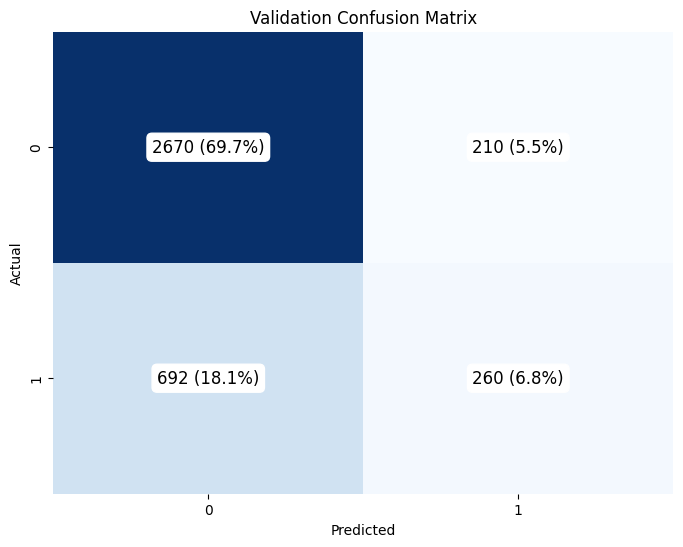

In [325]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

logreg = LogisticRegression()

# Fit the classifier on the training data
logreg.fit(X_train, y_train)

# Predict the classes for training and validation data
y_train_pred = logreg.predict(X_train)
y_val_pred = logreg.predict(X_val)

# Calculate performance metrics for training data
lr_train_accuracy = accuracy_score(y_train, y_train_pred)
lr_train_recall = recall_score(y_train, y_train_pred)
lr_train_precision = precision_score(y_train, y_train_pred)
lr_train_f1_score = f1_score(y_train, y_train_pred)

# Calculate performance metrics for validation data
lr_val_accuracy = accuracy_score(y_val, y_val_pred)
lr_val_recall = recall_score(y_val, y_val_pred)
lr_val_precision = precision_score(y_val, y_val_pred)
lr_val_f1_score = f1_score(y_val, y_val_pred)

print("Training Accuracy:", lr_train_accuracy)
print("Training Recall:", lr_train_recall)
print("Training Precision:", lr_train_precision)
print("Training F1 Score:", lr_train_f1_score)

print("Validation Accuracy:", lr_val_accuracy)
print("Validation Recall:", lr_val_recall)
print("Validation Precision:", lr_val_precision)
print("Validation F1 Score:", lr_val_f1_score)


# Create a confusion matrix for validation data
val_cm = confusion_matrix(y_val, y_val_pred)

# Normalize the confusion matrix to percentages
val_cm_percent = val_cm / np.sum(val_cm) * 100

# Define the class labels
class_labels = ['0', '1']

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Add the percentage values to the heatmap with adjusted spacing
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        value = f"{val_cm[i, j]} ({val_cm_percent[i, j]:.1f}%)"
        ax.text(j + 0.5, i + 0.5, value, ha='center', va='center', color='black', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='white', pad=0.3))

plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





### K-fold Cross Validation

In [326]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression

# Define the logistic regression classifier
logreg = LogisticRegression()

# Define the cross-validation method with 5 splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation on the training set
cv_results = cross_validate(logreg, X_train, y_train, cv=cv, scoring=scoring)

cv_results


{'fit_time': array([0.33312845, 0.30075359, 0.15678692, 0.15889978, 0.16353655]),
 'score_time': array([0.03738856, 0.01617956, 0.01712942, 0.01829863, 0.01533151]),
 'test_accuracy': array([0.77250979, 0.76598521, 0.75946064, 0.77511962, 0.7745866 ]),
 'test_precision': array([0.56198347, 0.63333333, 0.53900709, 0.54379562, 0.57518797]),
 'test_recall': array([0.24593128, 0.25249169, 0.26434783, 0.2754159 , 0.27419355]),
 'test_f1': array([0.34213836, 0.36104513, 0.35472579, 0.36564417, 0.37135922])}

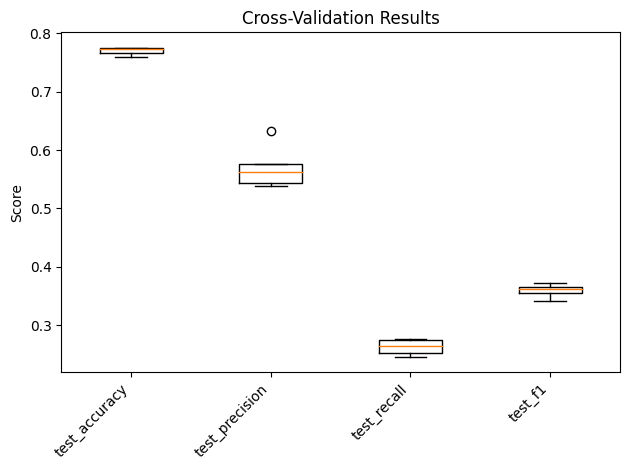

In [327]:
import matplotlib.pyplot as plt

# Define the scoring metrics
scoring_metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

# Prepare the data for the box plot
boxplot_data = [cv_results[metric] for metric in scoring_metrics]

# Create a box plot
plt.boxplot(boxplot_data, labels=scoring_metrics)
plt.title("Cross-Validation Results")
plt.ylabel("Score")

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


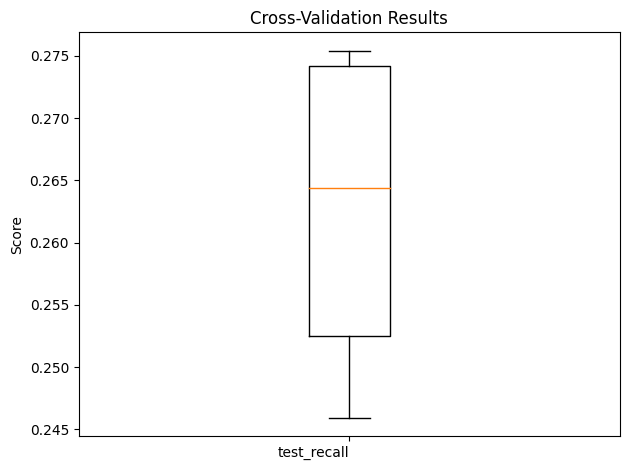

In [328]:
import matplotlib.pyplot as plt

# Define the scoring metrics
scoring_metrics = ['test_recall']

# Prepare the data for the box plot
boxplot_data = [cv_results[metric] for metric in scoring_metrics]

# Create a box plot
plt.boxplot(boxplot_data, labels=scoring_metrics)
plt.title("Cross-Validation Results")
plt.ylabel("Score")

# Rotate and align the x-axis labels
plt.xticks(ha='right')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


- * Performance on training set using the cross-validation varies between ~0.24 to ~0.27 recall


## Over_Sampling

In [329]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 2829
Before Oversampling, counts of label 'No': 8665 

After Oversampling, counts of label 'Yes': 8665
After Oversampling, counts of label 'No': 8665 

After Oversampling, the shape of train_X: (17330, 66)
After Oversampling, the shape of train_y: (17330,) 



Training Accuracy: 0.8290825158684363
Training Recall: 0.8038084246970572
Training Precision: 0.8466026498115959
Training F1 Score: 0.8246507222353777
Validation Accuracy: 0.7494780793319415
Validation Recall: 0.42436974789915966
Validation Precision: 0.4950980392156863
Validation F1 Score: 0.45701357466063347


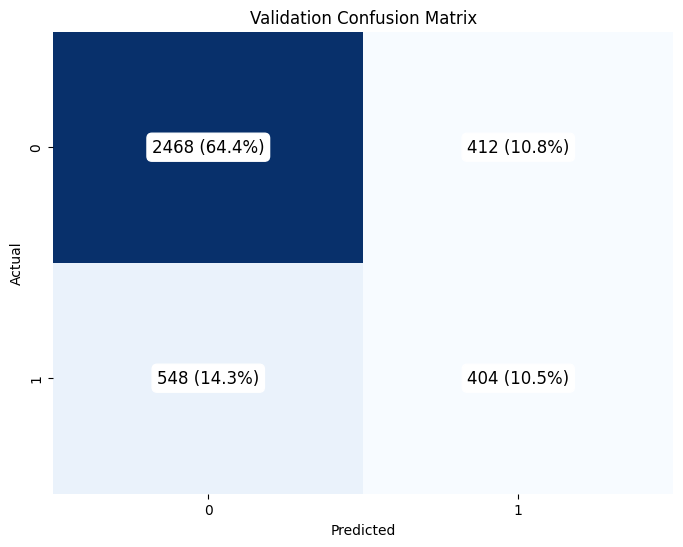

In [330]:
# Train a logistic regression model on the oversampled data
logreg1 = LogisticRegression()
logreg1.fit(X_train_over, y_train_over)

# Predict classes for training and validation data
y_train_pred = logreg1.predict(X_train_over)
y_val_pred = logreg1.predict(X_val)

# Print performance metrics for training data
oversampled_train_accuracy = accuracy_score(y_train_over, y_train_pred)
oversampled_train_recall = recall_score(y_train_over, y_train_pred)
oversampled_train_precision = precision_score(y_train_over, y_train_pred)
oversampled_train_f1_score = f1_score(y_train_over, y_train_pred)

print("Training Accuracy:", oversampled_train_accuracy)
print("Training Recall:", oversampled_train_recall)
print("Training Precision:", oversampled_train_precision)
print("Training F1 Score:", oversampled_train_f1_score)

# Print performance metrics for validation data
oversampled_val_accuracy = accuracy_score(y_val, y_val_pred)
oversampled_val_recall = recall_score(y_val, y_val_pred)
oversampled_val_precision = precision_score(y_val, y_val_pred)
oversampled_val_f1_score = f1_score(y_val, y_val_pred)

print("Validation Accuracy:", oversampled_val_accuracy)
print("Validation Recall:", oversampled_val_recall)
print("Validation Precision:", oversampled_val_precision)
print("Validation F1 Score:", oversampled_val_f1_score)

# Create a confusion matrix for validation data
val_cm = confusion_matrix(y_val, y_val_pred)

# Normalize the confusion matrix to percentages
val_cm_percent = val_cm / np.sum(val_cm) * 100

# Define the class labels
class_labels = ['0', '1']

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Add the percentage values to the heatmap with adjusted spacing
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        value = f"{val_cm[i, j]} ({val_cm_percent[i, j]:.1f}%)"
        ax.text(j + 0.5, i + 0.5, value, ha='center', va='center', color='black', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='white', pad=0.3))

plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




### K- Fold

In [331]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression

# Define the logistic regression classifier
logreg = LogisticRegression()

# Define the cross-validation method with 5 splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation on the training set
cv_results = cross_validate(logreg, X_train_over, y_train_over, cv=cv, scoring=scoring)

cv_results


{'fit_time': array([0.29335237, 0.22808146, 0.23275781, 0.27050233, 0.24725103]),
 'score_time': array([0.0308187 , 0.0200119 , 0.02029705, 0.01988125, 0.01852179]),
 'test_accuracy': array([0.82804385, 0.83035199, 0.83092902, 0.82458165, 0.81794576]),
 'test_precision': array([0.83195755, 0.8488228 , 0.83772455, 0.8494161 , 0.86204704]),
 'test_recall': array([0.81939605, 0.79929988, 0.81621937, 0.79197708, 0.76610169]),
 'test_f1': array([0.82562902, 0.82331731, 0.82683215, 0.81969158, 0.81124738])}

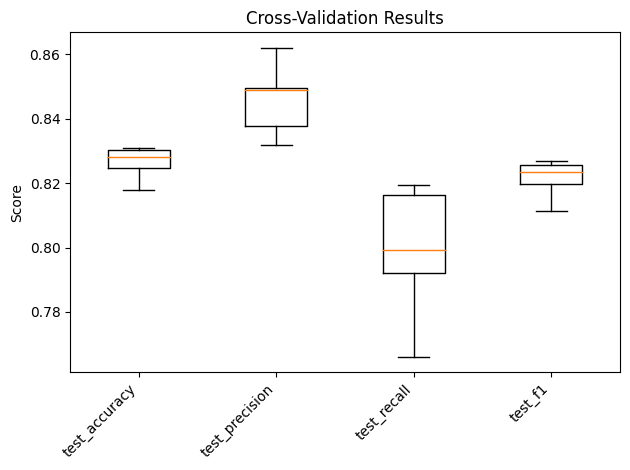

In [332]:
import matplotlib.pyplot as plt

# Define the scoring metrics
scoring_metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

# Prepare the data for the box plot
boxplot_data = [cv_results[metric] for metric in scoring_metrics]

# Create a box plot
plt.boxplot(boxplot_data, labels=scoring_metrics)
plt.title("Cross-Validation Results")
plt.ylabel("Score")

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


## Under_Sampling

In [333]:
from imblearn.under_sampling import RandomUnderSampler

print("Before Undersampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

rus = RandomUnderSampler(random_state=1)  # Random Undersampling

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(sum(y_train_under == 0)))

print("After Undersampling, the shape of train_X: {}".format(X_train_under.shape))
print("After Undersampling, the shape of train_y: {} \n".format(y_train_under.shape))


Before Undersampling, counts of label 'Yes': 2829
Before Undersampling, counts of label 'No': 8665 

After Undersampling, counts of label 'Yes': 2829
After Undersampling, counts of label 'No': 2829 

After Undersampling, the shape of train_X: (5658, 66)
After Undersampling, the shape of train_y: (5658,) 



Training Accuracy: 0.7401908801696713
Training Recall: 0.7327677624602333
Training Precision: 0.7438105489773951
Training F1 Score: 0.7382478632478633
Validation Accuracy: 0.7361691022964509
Validation Recall: 0.7153361344537815
Validation Precision: 0.4792399718508093
Validation F1 Score: 0.5739570164348926


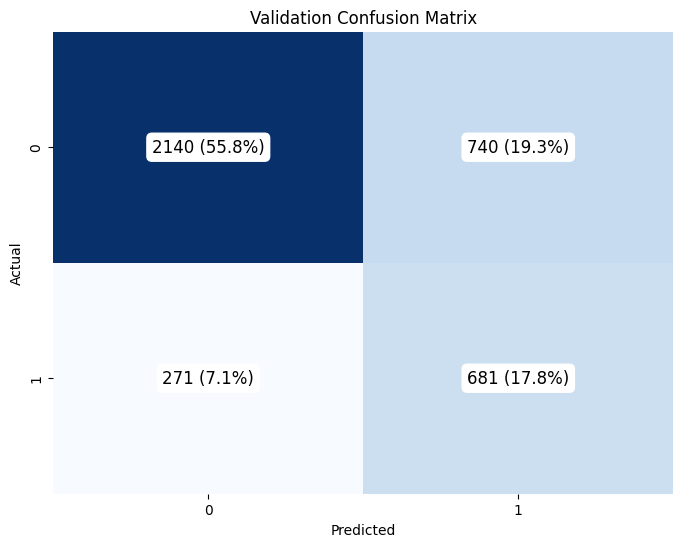

In [334]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

# Perform random undersampling
rus = RandomUnderSampler(random_state=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# Train a logistic regression model on the undersampled data
logreg2 = LogisticRegression()
logreg2.fit(X_train_under, y_train_under)

# Predict classes for training and validation data
y_train_pred = logreg2.predict(X_train_under)
y_val_pred = logreg2.predict(X_val)

# Print performance metrics for training data
undersampled_train_accuracy = accuracy_score(y_train_under, y_train_pred)
undersampled_train_recall = recall_score(y_train_under, y_train_pred)
undersampled_train_precision = precision_score(y_train_under, y_train_pred)
undersampled_train_f1_score = f1_score(y_train_under, y_train_pred)

print("Training Accuracy:", undersampled_train_accuracy)
print("Training Recall:", undersampled_train_recall)
print("Training Precision:", undersampled_train_precision)
print("Training F1 Score:", undersampled_train_f1_score)

# Print performance metrics for validation data
undersampled_val_accuracy = accuracy_score(y_val, y_val_pred)
undersampled_val_recall = recall_score(y_val, y_val_pred)
undersampled_val_precision = precision_score(y_val, y_val_pred)
undersampled_val_f1_score = f1_score(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation Precision:", val_precision)
print("Validation F1 Score:", val_f1_score)

# Create a confusion matrix for validation data
val_cm = confusion_matrix(y_val, y_val_pred)

# Normalize the confusion matrix to percentages
val_cm_percent = val_cm / np.sum(val_cm) * 100

# Define the class labels
class_labels = ['0', '1']

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Add the percentage values to the heatmap with adjusted spacing
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        value = f"{val_cm[i, j]} ({val_cm_percent[i, j]:.1f}%)"
        ax.text(j + 0.5, i + 0.5, value, ha='center', va='center', color='black', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='white', pad=0.3))

plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### K-**fold**

In [335]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression

# Define the logistic regression classifier
logreg = LogisticRegression()

# Define the cross-validation method with 5 splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation on the training set
cv_results = cross_validate(logreg, X_train_under, y_train_under, cv=cv, scoring=scoring)

cv_results


{'fit_time': array([0.1216681 , 0.09187746, 0.09146619, 0.11352611, 0.08917427]),
 'score_time': array([0.01270056, 0.01282501, 0.01463675, 0.01276994, 0.01302791]),
 'test_accuracy': array([0.73939929, 0.74293286, 0.70759717, 0.73121132, 0.73563218]),
 'test_precision': array([0.72172352, 0.75095785, 0.7338403 , 0.74025974, 0.75127768]),
 'test_recall': array([0.74169742, 0.70886076, 0.66897747, 0.70870337, 0.74242424]),
 'test_f1': array([0.73157416, 0.72930233, 0.69990934, 0.72413793, 0.74682472])}

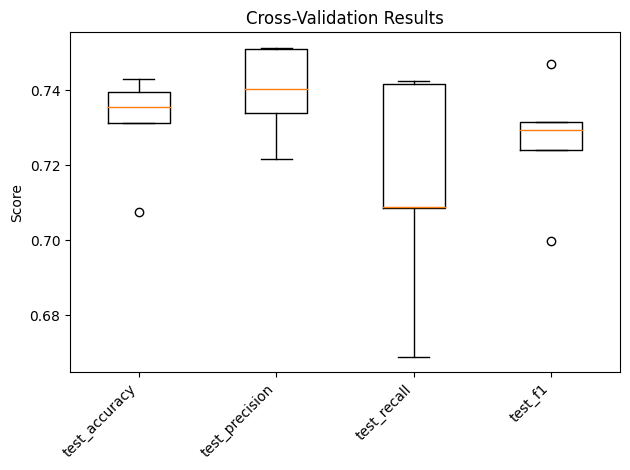

In [336]:
import matplotlib.pyplot as plt

# Define the scoring metrics
scoring_metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

# Prepare the data for the box plot
boxplot_data = [cv_results[metric] for metric in scoring_metrics]

# Create a box plot
plt.boxplot(boxplot_data, labels=scoring_metrics)
plt.title("Cross-Validation Results")
plt.ylabel("Score")

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


## Summary - Comparison of Models

In [337]:
# Create a summary comparison dataframe
summarydf = {
    'Metric': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
    'Logistic Regression (Training)': [lr_train_accuracy, lr_train_recall, lr_train_precision, lr_train_f1_score],
    'Logistic Regression (Validation)': [lr_val_accuracy, lr_val_recall, lr_val_precision, lr_val_f1_score],
    'Logistic Regression with Oversampling (Training)': [oversampled_train_accuracy, oversampled_train_recall, oversampled_train_precision, oversampled_train_f1_score],
    'Logistic Regression with Oversampling (Validation)': [oversampled_val_accuracy, oversampled_val_recall, oversampled_val_precision, oversampled_val_f1_score],
    'Logistic Regression with Undersampling (Training)': [undersampled_train_accuracy, undersampled_train_recall, undersampled_train_precision, undersampled_train_f1_score],
    'Logistic Regression with Undersampling (Validation)': [undersampled_val_accuracy, undersampled_val_recall, undersampled_val_precision, undersampled_val_f1_score]
}

df = pd.DataFrame(summarydf)
df.set_index('Metric', inplace=True)
df

,Logistic Regression (Training),Logistic Regression (Validation),Logistic Regression with Oversampling (Training),Logistic Regression with Oversampling (Validation),Logistic Regression with Undersampling (Training),Logistic Regression with Undersampling (Validation)
Metric,,,,,,
Accuracy,0.772751,0.764614,0.829083,0.749478,0.740191,0.736169
Recall,0.282785,0.273109,0.803808,0.424370,0.732768,0.715336
Precision,0.578453,0.553191,0.846603,0.495098,0.743811,0.479240
F1 Score,0.379867,0.365682,0.824651,0.457014,0.738248,0.573957


- * Logistic regression model on undersampled data has given a generalized performance with the highest recall on validation data, so we will consider it as our final model

In [338]:

# Predict the classes for the unseen data
y_test_pred = logreg2.predict(X_test)

# Calculate performance metrics for the unseen data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)

# Print the performance metrics for the unseen data
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1_score)


Test Accuracy: 0.7280793319415448
Test Recall: 0.7098393574297188
Test Precision: 0.48424657534246573
Test F1 Score: 0.5757328990228012


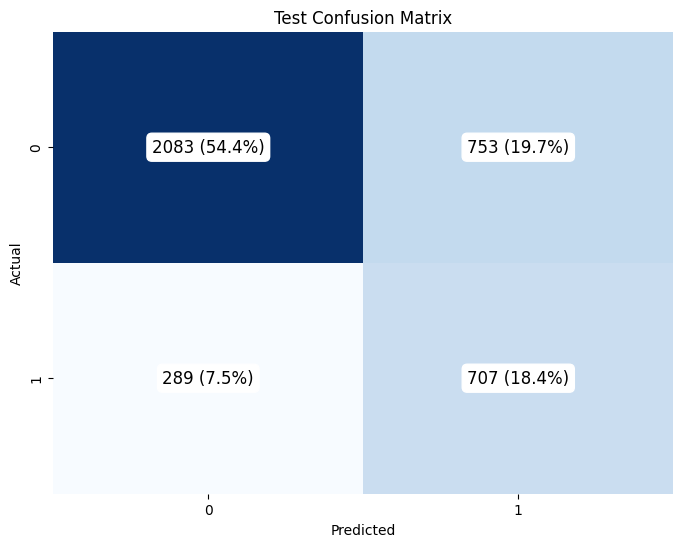

In [339]:
# Create a confusion matrix for test data
test_cm = confusion_matrix(y_test, y_test_pred)

# Normalize the confusion matrix to percentages
test_cm_percent = test_cm / np.sum(test_cm) * 100

# Define the class labels
class_labels = ['0', '1']

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Add the percentage values to the heatmap with adjusted spacing
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        value = f"{test_cm[i, j]} ({test_cm_percent[i, j]:.1f}%)"
        ax.text(j + 0.5, i + 0.5, value, ha='center', va='center', color='black', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='white', pad=0.3))

plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


- - Model trained with undersampled data has given generalised performance on the test set

In [340]:
# let us check the coefficients and intercept of the model (lin. and log. reg. sklearn)

coef_df = pd.DataFrame(
    np.append(logreg2.coef_, logreg2.intercept_),
    index=X_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df.T

,city_development_index,training_hours,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,city_Under_developed,city_Developing,city_Developed,gender_Female,gender_Male,gender_Other,...,company_size_500-999,company_size_5000-9999,company_size_<10,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,Intercept
Coefficients,-0.734948,-0.000941,0.165977,0.322953,1.18956,-0.379702,-0.320928,0.052201,-0.159885,-0.173194,...,-1.166095,-1.164459,-1.236633,-0.021425,0.100669,0.233088,0.106137,0.316075,-0.268382,0.513264


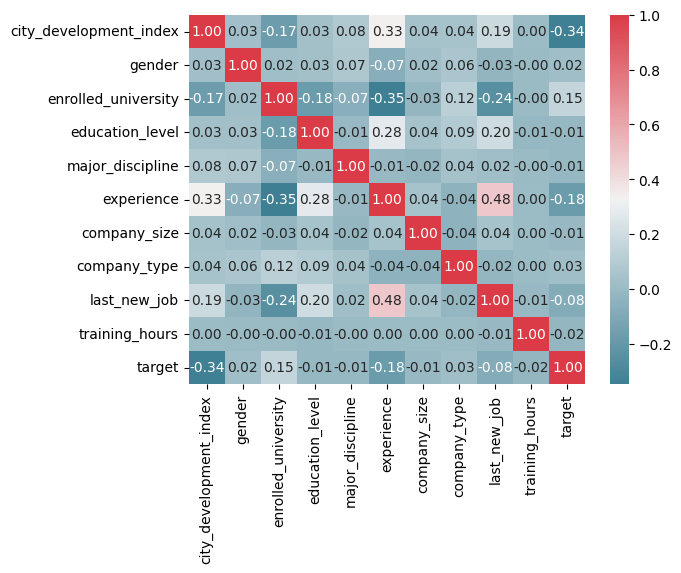

In [341]:
# Select only numerical columns
num_cols = data.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
corr_matrix = num_cols.corr()

# Plot the correlation matrix
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Define a custom color palette
sns.heatmap(corr_matrix, cmap=cmap, annot=True, fmt='.2f')

# Show the plot
plt.show()
